In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from tqdm.autonotebook import tqdm
plt.rcParams['figure.figsize'] = 20, 8
%config Completer.use_jedi = False

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
import darts

%load_ext autoreload
%autoreload 2

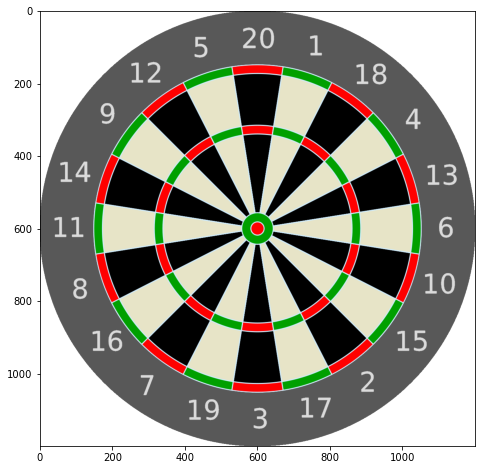

In [3]:
db_png = mpimg.imread('C:/Users/mikey/Downloads/dartboard.png')
plt.imshow(db_png)

147 -> 1052 = 905

So 905 pixels = diameter of board = 380mm #451mm

So 1 pixel = 0.41988mm      #0.4983mm

In [155]:
600 * 0.41988

251.928

In [156]:
1200*380/905*0.5

251.93370165745856

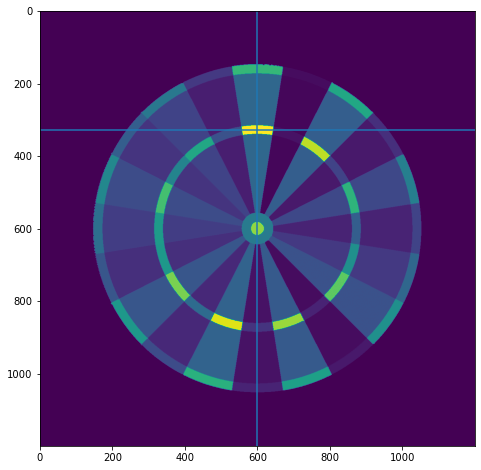

In [157]:
# Center of the triple 20
plt.imshow(db)
plt.axhline(327)
plt.axvline(600)

### Method 1 - FFTs

In [158]:
scale = 252 # 1200 pixels * 0.41988mm/pixel = 504 total width
x, y = np.meshgrid(np.linspace(-scale,scale,1200), np.linspace(-scale,scale,1200))
d = np.sqrt(3*x*x + y*y)
sigma = 10 # in mm
g = np.exp(-( d**2 / ( 2.0 * sigma**2 ) ) )
g /= g.sum()

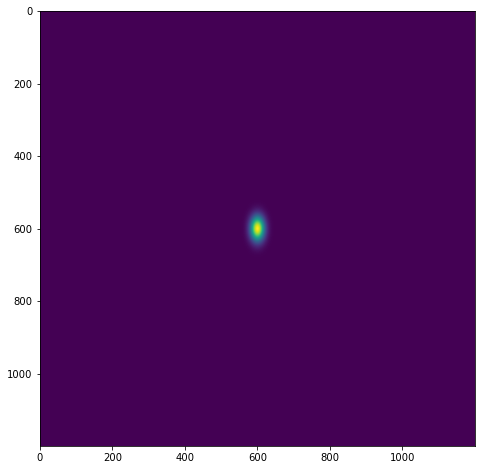

In [159]:
plt.imshow(g)

In [230]:
db_ft = np.fft.fft2(db)
g_slice_ft = np.fft.fft2(np.fft.ifftshift(h))

In [232]:
prod_ft = db_ft * g_slice_ft

exp_map = np.real(np.fft.ifft2(prod_ft))

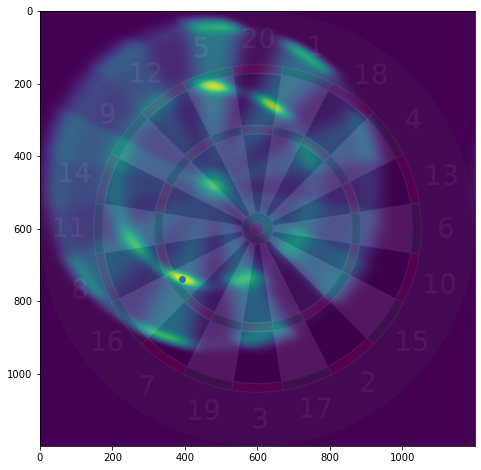

In [233]:
plt.imshow(exp_map)
plt.imshow(db_png, alpha=0.1)

i, j = np.unravel_index(exp_map.argmax(), exp_map.shape)
plt.scatter(j, i)

Put into function:

In [92]:
def exp_score_map(sigma, db=db):
    assert sigma>=0.01, "sigma too small!"
    scale = 252 # 1200 pixels * 0.41988mm/pixel = 504 total width
    x, y = np.meshgrid(np.linspace(-scale,scale,1200), np.linspace(-scale,scale,1200))
    d = np.sqrt(x*x + y*y)
    g = np.exp(-( d**2 / ( 2.0 * sigma**2 ) ) )
    g /= g.sum()
    
    db_ft = np.fft.fft2(db)
    g_slice_ft = np.fft.fft2(np.fft.ifftshift(g))
    
    prod_ft = db_ft * g_slice_ft
    exp_map = np.real(np.fft.ifft2(prod_ft))
    
    return exp_map

Text(100, 100, 'σ = 10.00')

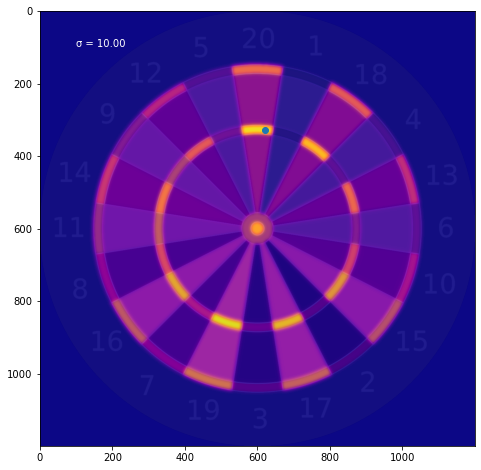

In [93]:
exp_map = exp_score_map(2)
plt.imshow(exp_map, cmap='plasma')
plt.imshow(db_png, alpha=0.1)

i, j = np.unravel_index(exp_map.argmax(), exp_map.shape)
plt.scatter(j, i)
plt.text(100, 100, f'σ = {sigma:.2f}', color='white')

In [94]:
y_coords = []
maxes = []
for sigma in tqdm(np.linspace(0.01, 30, 150)):
    exp_map = exp_score_map(sigma)
    i, j = np.unravel_index(exp_map.argmax(), exp_map.shape)
    maxes.append(np.max(exp_map))
    y_coords.append(i)

  0%|          | 0/150 [00:00<?, ?it/s]

In [95]:
df = pd.DataFrame(list(zip(np.linspace(0.01, 30, 150), maxes, y_coords)), 
                  columns=['sigma', 'max_score', 'y_coord']).set_index('sigma')

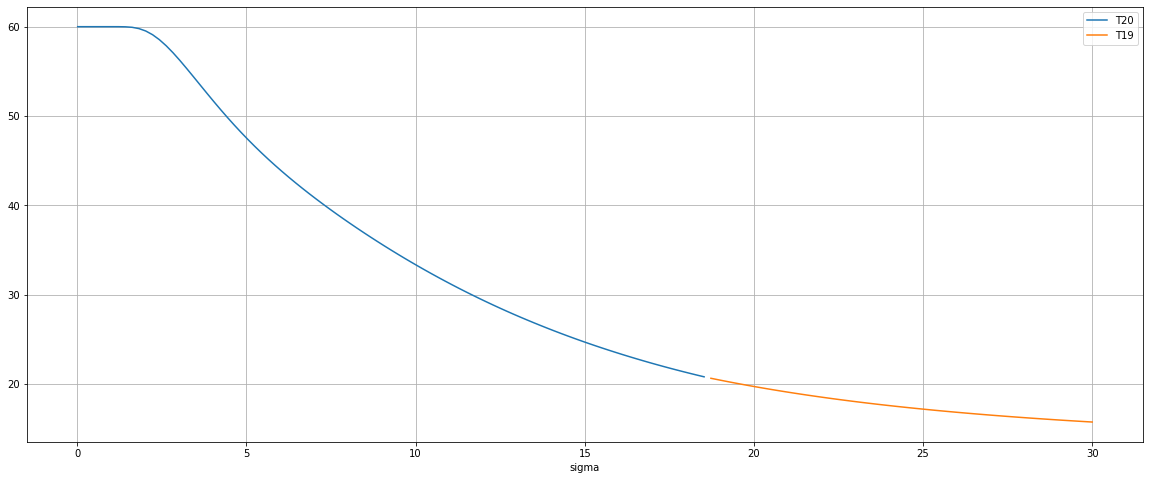

In [96]:
df[df.y_coord < 600].max_score.plot(label='T20')
df[df.y_coord > 600].max_score.plot(label='T19')
plt.grid()
plt.legend()

In [97]:
import scipy.optimize as opt

In [98]:
target = 34

def opt_fn(sigma):
    exp_map = exp_score_map(sigma)
    return np.max(exp_map) - target

opt.root_scalar(opt_fn, x0=5, x1=10)

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 9.704001949605095

### Variance

In [99]:
db2 = db*db

In [100]:
sigma=20

In [101]:
exp2_map = exp_score_map(sigma, db=db2)
exp_map = exp_score_map(sigma, db=db)

In [102]:
std_map = np.sqrt(np.abs(exp2_map - exp_map*exp_map))

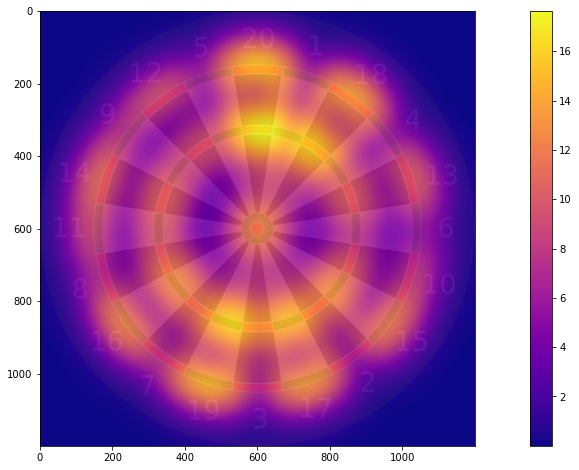

In [103]:
plt.imshow(std_map, cmap='plasma')
plt.colorbar()
plt.imshow(db_png, alpha=0.1)

In [104]:
i, j = np.unravel_index(exp_map.argmax(), exp_map.shape)

In [105]:
i, j

(863, 505)

In [106]:
np.sqrt(3)*std_map[i, j]

26.561912525236618

In [107]:
3*exp_map[i, j]

59.129307534473035

In [108]:
y_coords = []
maxes = []
stds = []
for sigma in tqdm(np.linspace(0.01, 30, 1000)):
    exp_map = exp_score_map(sigma, db=db)
    exp2_map = exp_score_map(sigma, db=db2)
    
    std_map = np.sqrt(np.abs(exp2_map - exp_map*exp_map))
    
    i, j = np.unravel_index(exp_map.argmax(), exp_map.shape)
    
    maxes.append(np.max(exp_map))
    y_coords.append(i)
    stds.append(std_map[i, j])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [109]:
df = pd.DataFrame(list(zip(np.linspace(0.01, 30, 1000), maxes, y_coords, stds)), 
                  columns=['sigma', 'max_score', 'y_coord', 'std']).set_index('sigma')

In [110]:
df

,max_score,y_coord,std
sigma,,,
0.01000,60.000000,319,0.000001
0.04002,60.000000,319,0.000001
0.07004,60.000000,316,0.000002
0.10006,60.000000,316,0.000002
0.13008,60.000000,328,0.000002
...,...,...,...
29.87992,15.755231,859,12.870234
29.90994,15.748549,859,12.866198
29.93996,15.741883,858,12.860917


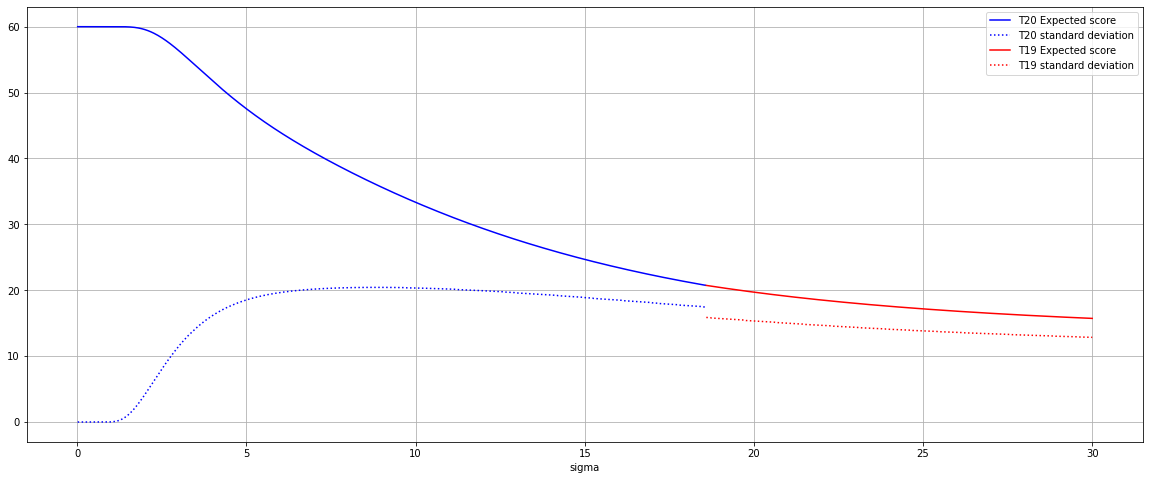

In [111]:
fig, ax = plt.subplots(1)
df[df.y_coord < 600].max_score.plot(c='b', ax=ax, label='T20 Expected score')
df[df.y_coord < 600]['std'].plot(c='b', style=':', ax=ax, label='T20 standard deviation')
df[df.y_coord > 600].max_score.plot(c='r', ax=ax, label='T19 Expected score')
df[df.y_coord > 600]['std'].plot(c='r', style=':', ax=ax, label='T19 standard deviation')
ax.grid()
ax.legend()
fig.savefig('darts_mean_std')

### Animations

In [35]:
import matplotlib.animation as animation
from IPython.display import HTML

In [55]:
def exp_map_animation(sigma_min, sigma_max, sigma_points, interval):
    images = []
    fig = plt.figure(figsize=(10, 10))

    for sigma in tqdm(np.linspace(0.01, 100, 50)):
        exp_map = exp_score_map(sigma)

        i, j = np.unravel_index(exp_map.argmax(), exp_map.shape)
        images.append((plt.imshow(exp_map, cmap='plasma', animated=True), 
                       plt.imshow(db_png, alpha=0.15),
                       plt.scatter(j, i, c='b'),
                       plt.text(100, 100, f'σ = {sigma:.2f}', color='white')))
    
    ani = animation.ArtistAnimation(fig, images, interval=interval, blit=True,
                                    repeat_delay=1000)
    
    #ani.save(filename)
    return HTML(ani.to_html5_video())

  0%|          | 0/50 [00:00<?, ?it/s]

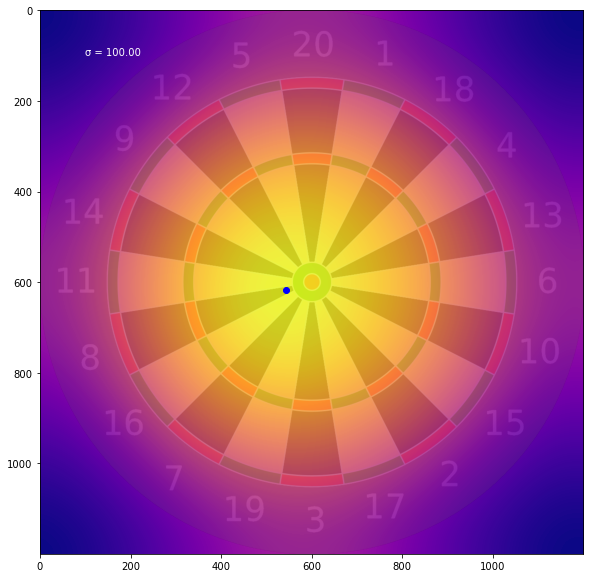

In [56]:
exp_map_animation(1, 100, 50, 100)

## Dartboard class

In [163]:
dboard = darts.Dartboard()

In [164]:
dboard.generate_dartboard(2001)

Working on slice 14
Working on slice 9
Working on slice 12
Working on slice 5
Working on slice 20
Working on slice 1
Working on slice 18
Working on slice 4
Working on slice 13
Working on slice 6
Working on slice 10
Working on slice 15
Working on slice 2
Working on slice 17
Working on slice 3
Working on slice 19
Working on slice 7
Working on slice 16
Working on slice 8


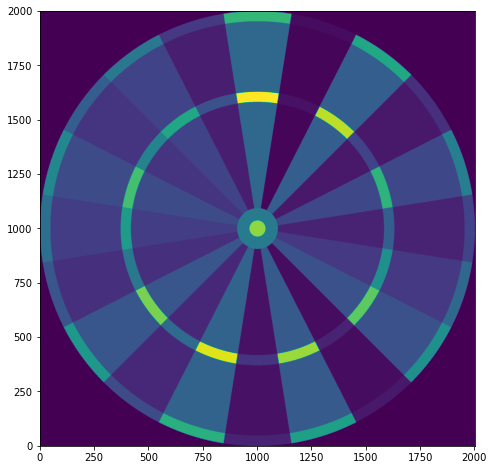

In [150]:
plt.imshow(dboard.db_score_map, origin='lower')

In [151]:
mu = np.array([0, 0])
Sigma = np.array([[100, 0], [0, 100]])

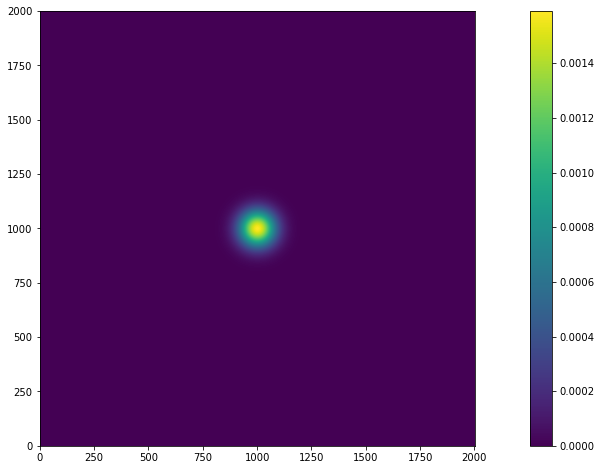

In [152]:
plt.imshow(dboard.gaussian_filter(mu, Sigma), origin='lower')
plt.colorbar()

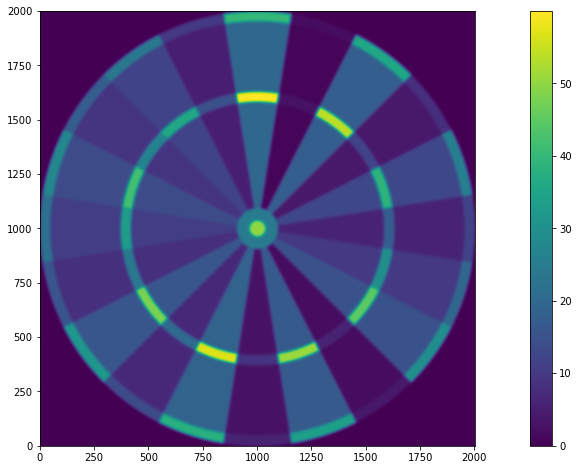

In [622]:
plt.imshow(dboard.exp_score_map(mu, 0.01*Sigma, padding=100), origin='lower')
plt.colorbar()

In [55]:
a=dboard.exp_score_map(np.array([0, 0]), Sigma, padding=500)

In [62]:
np.unravel_index(a.argmax(), a.shape)[::-1]

(995, 1606)

In [64]:
a[np.unravel_index(a.argmax(), a.shape)[::-1]]

10.646503166081006

In [13]:
from scipy.signal import convolve2d

In [38]:
c = convolve2d(dboard.db_score_map, np.array([[1,1,1],[1,-8,1],[1,1,1]]), mode='same')
c = c != 0

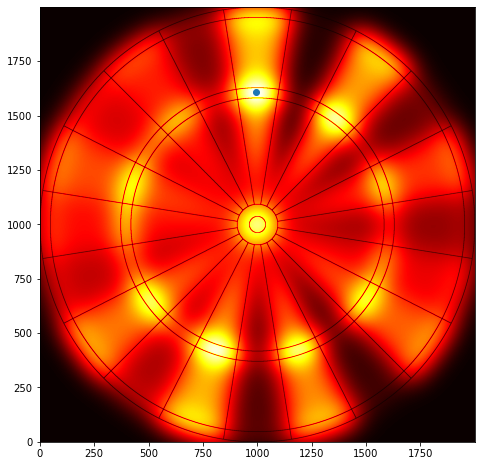

In [58]:
plt.imshow(np.where(c != 0, 0.0, a), origin='lower', cmap='hot')
plt.scatter(995, 1606)

In [94]:
idx, m = dboard.optimal_aim(a, units='pixel')

In [114]:
idx

array([1606,  995], dtype=int64)

In [97]:
a[idx[0], idx[1]]

29.51926037399153

In [ ]:
hot, jet, gist_heat

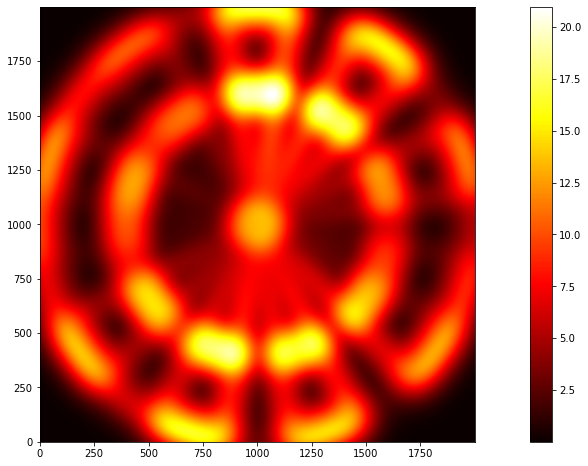

In [85]:
plt.imshow(dboard.std_score_map(mu, Sigma, padding=500), origin='lower', cmap='hot')
plt.colorbar()

In [146]:
scores = []
stds = []
x_idxs = []
y_idxs = []
sigmas = np.linspace(0.01, 60, 500)

for s in tqdm(sigmas):
    sigma = s**2 * np.eye(2)
    m = np.zeros(2)
    
    exp_map = dboard.exp_score_map(mu, sigma, padding=500)
    std_map = dboard.std_score_map(mu, sigma, padding=500)
    
    max_idx, max_score = dboard.optimal_aim(exp_map, unit='pixel')
    
    scores.append(max_score)
    x_idxs.append(max_idx[1])
    y_idxs.append(max_idx[0])
    stds.append(std_map[max_idx[0], max_idx[1]])

  0%|          | 0/500 [00:00<?, ?it/s]

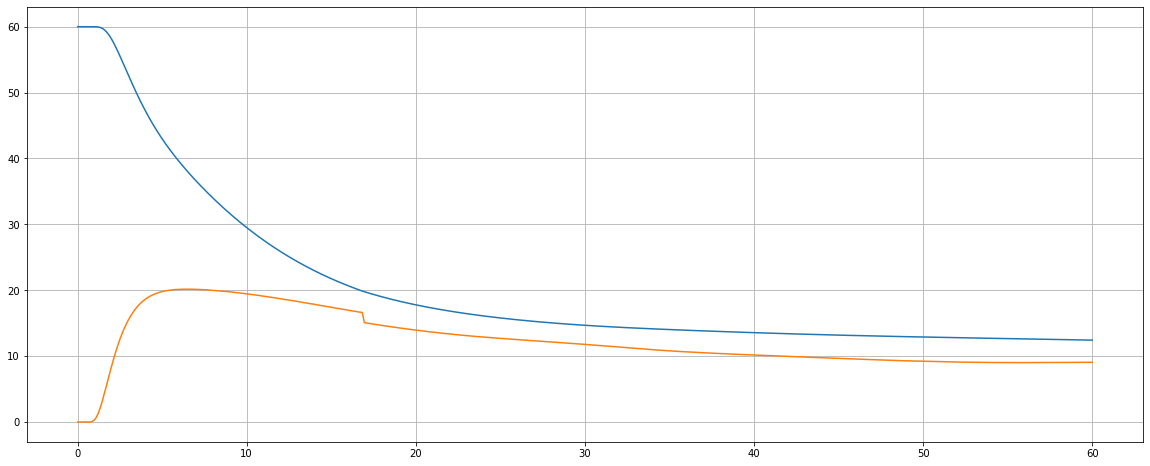

In [147]:
plt.plot(sigmas, scores)
plt.plot(sigmas, stds)
plt.grid()

In [148]:
df = pd.DataFrame(list(zip(sigmas, scores, x_idxs, y_idxs, stds)), 
                  columns=['sigma', 'max_score', 'x_idx', 'y_idx', 'stds']).set_index('sigma')

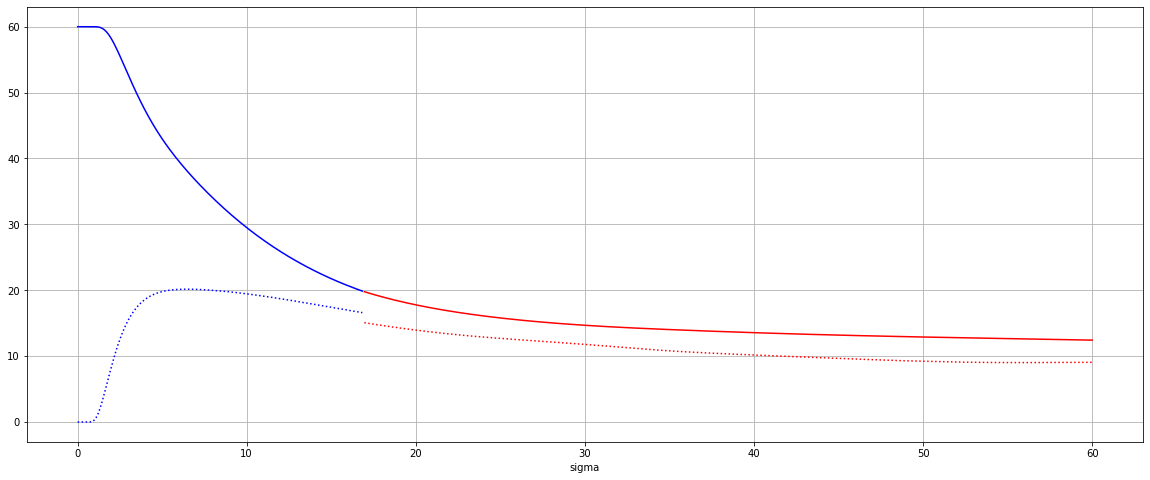

In [149]:
df[df.y_idx>1200].max_score.plot(c='b')
df[df.y_idx<1200].max_score.plot(c='r')
df[df.y_idx>1200].stds.plot(c='b', style=':')
df[df.y_idx<1200].stds.plot(c='r', style=':')
plt.grid()

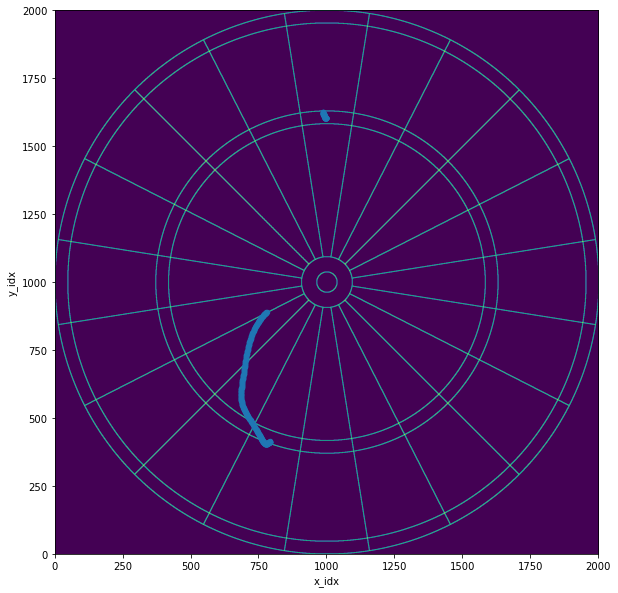

In [155]:
df[df.index>5].plot.scatter('x_idx', 'y_idx', figsize=(10, 10))
plt.ylim(0, 2000)
plt.xlim(0, 2000)
plt.imshow(c)

In [157]:
df.to_csv('symmetric_gaussian_throw_maxes.csv')

In [154]:
df.head()

,max_score,x_idx,y_idx,stds
sigma,,,,
0.010000,60.0,1081,1602,1.348699e-06
0.130220,60.0,1035,1604,1.348699e-06
0.250441,60.0,1035,1593,1.348699e-06
0.370661,60.0,1003,1602,1.784161e-06
0.490882,60.0,1034,1604,9.536743e-07


In [322]:
np.sum(weights * z2.T, axis=2)

array([[0.00277233, 0.05652696],
       [0.05652696, 1.1540541 ]])

In [311]:
z2 = np.array([np.outer(w,w) for w in z])

In [240]:
z = y[:100, :]

In [235]:
multivariate_normal(mu, Sigma).pdf([[10, 0], [0, 0]])

array([0.00096532, 0.00159155])

In [223]:
from scipy.stats import multivariate_normal

In [222]:
np.random.choice(range(100), 4)

array([70, 76, 43, 60])

In [221]:
y.shape

(141250, 2)

In [219]:
y = np.array(np.where(dboard.db_score_map==3)).T

In [214]:
y = [(i, j) for i, j in zip(*np.where(dboard.db_score_map==3))]

In [95]:
dboard.score_at_point(*dboard.pixel_to_point(*y[20]))

20

In [115]:
dboard.pixel_to_point(y[100])

array([  19.38, -104.72])

In [208]:
z = [dboard.score_at_point(dboard.pixel_to_point(i)) for i in y]

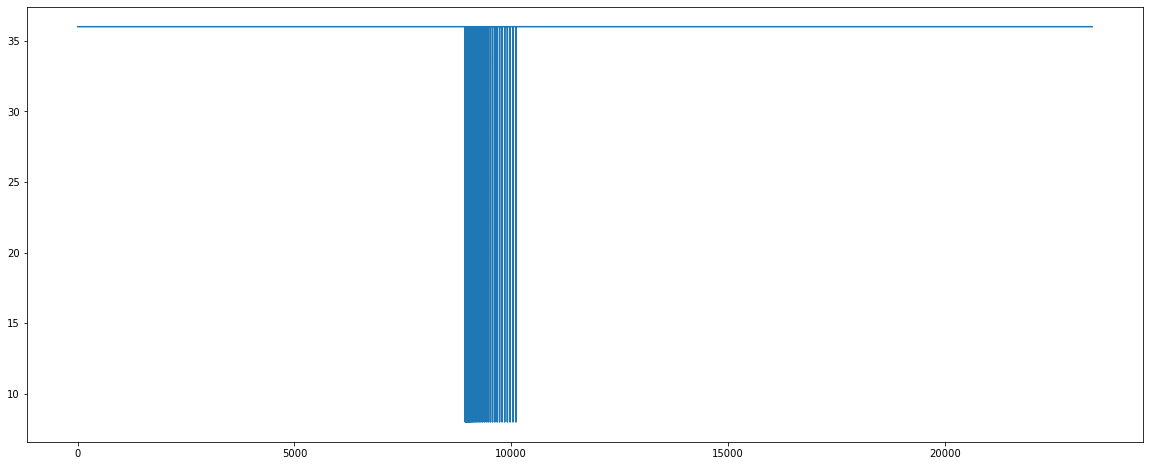

In [201]:
plt.plot(z)

In [499]:
dis = darts.ThrowingDistribution()

In [500]:
dis.generate_dartboard(2001)

Working on slice 14
Working on slice 9
Working on slice 12
Working on slice 5
Working on slice 20
Working on slice 1
Working on slice 18
Working on slice 4
Working on slice 13
Working on slice 6
Working on slice 10
Working on slice 15
Working on slice 2
Working on slice 17
Working on slice 3
Working on slice 19
Working on slice 7
Working on slice 16
Working on slice 8


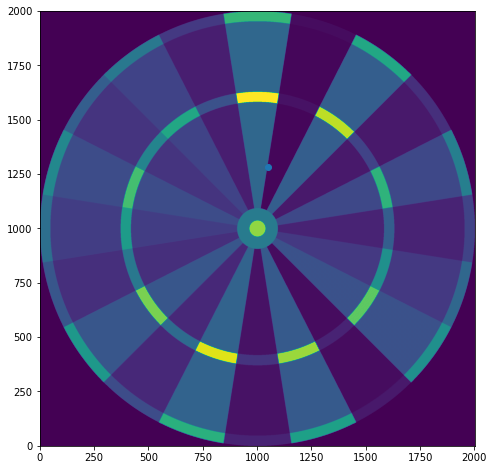

In [367]:
plt.imshow(dboard.db_score_map, origin ='lower')
plt.scatter(*[1048.85943602, 1281.10316002])

In [617]:
_, _, ls = dis.estimate_distribution(y, tol=.01, return_params=True)

[11.91379091 -0.39225523] -40204.62413874414 nan nan
[16.84142744 -0.12215473] -11763.436756066043 -40204.62413874414 0.7074108511630152
[18.27832882 -0.11498423] 26151.977721835043 -25984.030447405094 2.0064634805123824
[18.03810786 -0.03405891] 4287.9225651012675 -8605.361057658381 1.4982850267839967
[17.641711    0.12392426] -16482.087988367242 -5382.040151968469 2.062423824976288
[18.09457212 -0.07484627] -18148.365406285575 -7602.0497192482235 1.3872989623225314
[18.3134163  -0.07789087] -21286.85921313802 -3190.79797275651 5.671327797901426
[18.41416644 -0.05758606] -24448.47842199313 -5095.482464170906 3.798069386736901
[18.69643767 -0.03409832] -24561.656673480764 -15215.573692936541 0.6142445345247096
[18.81303595 -0.07450339] -25770.039550626207 -20985.489540652947 0.2279932522281485
[18.93783539 -0.06078931] -26573.932566038184 -22843.07985310474 0.16332529312707195
[19.03963615 -0.05754636] -27343.049992484688 -24528.193285055262 0.11476005080017389
[19.12925718 -0.05650557

In [618]:
dis.mu

array([19.91373949, -0.05626928])

In [619]:
dis.Sigma

array([[90.97822553,  0.85855457],
       [ 0.85855457, 94.58419192]])

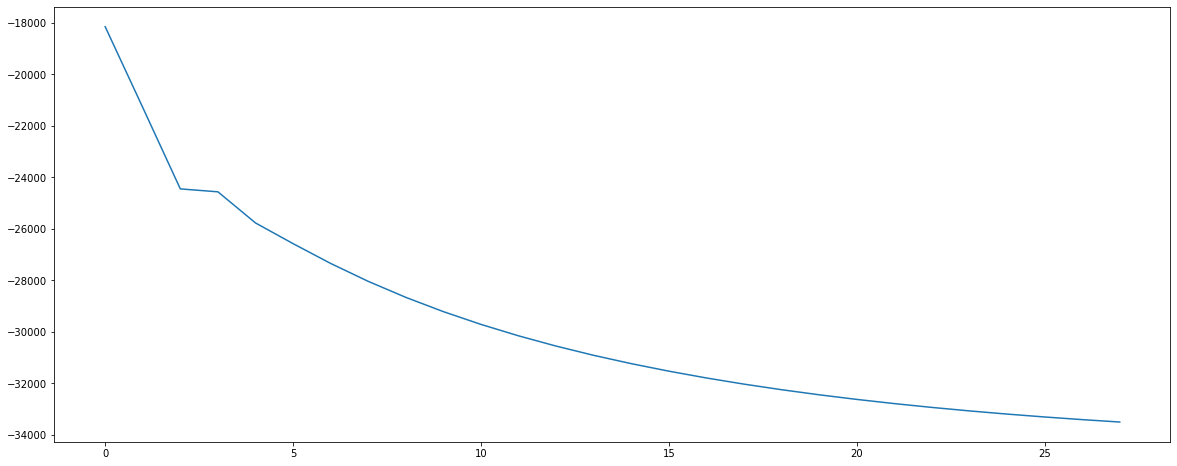

In [620]:
plt.plot(ls[5:])

In [616]:
y = [dboard.score_at_point(i) for i in multivariate_normal(np.array([20,0]), Sigma).rvs(10000)]

In [583]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 25, 50])

In [549]:
from matplotlib.patches import Ellipse

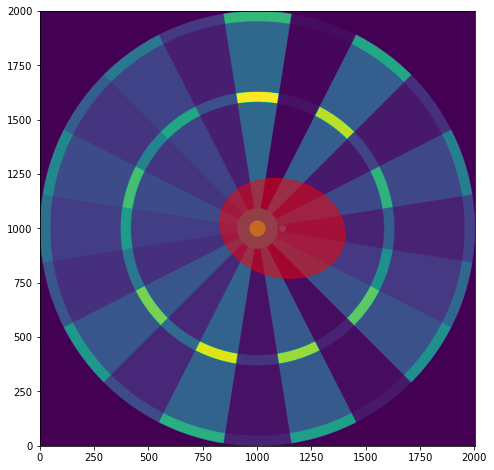

In [615]:
width, height = np.linalg.eigvals(dis.Sigma)/dis.mm_per_pixel
v = np.linalg.eig(dis.Sigma)[1][0]
angle = np.degrees(-np.arctan2(v[0], v[1]))

ell = Ellipse(xy=dboard.point_to_pixel(dis.mu[::-1]), width=width, height=height, angle=angle, color='red', alpha=0.5)
fig, ax = plt.subplots(1)
ax.imshow(dboard.db_score_map, origin ='lower')
ax.add_patch(ell)
ax.scatter(*dboard.point_to_pixel(dis.mu[::-1]))

In [494]:
gaussian_estimate = multivariate_normal(mu, Sigma).pdf
dis._moment_z_given_x(mu, Sigma, 2, 20, N=1000000)

computing gaussians
calculating arg
integral estimate


array([[3.70037691e+00, 2.31990224e-02],
       [2.31990224e-02, 4.49047071e+02]])